<a href="https://colab.research.google.com/github/F1ameX/SHIFT_entrance_2025/blob/main/shift_entrance_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вступительное испытание на ШИФТ Курсы: Кто прошёл через турникеты?

## 0. Вступление

**Описание**

В виде входных данных предоставлены логи посещений здания, в которых фиксируются следующие параметры:
- **ID пользователя**
- **Время прохода**
- **Номер турникета**

Проход через турникет фиксируется при входе в здание, а также при открытии парковки или входе на этаж с помощью "таблетки". Записи были сделаны за один год.

В новом году произошел сбой, из-за которого ID пользователей перемешались. Задача — восстановить правильные ID пользователей, используя характерные паттерны в их поведении.

В тестовой выборке ID посетителей перемешаны. Необходимо разработать алгоритм,который сможет сопоставить новый (ошибочный) ID со старым (правильным) ID, используя данные за предыдущий год.

Необходимо подготовить таблицу предсказаний с двумя колонками:
- **lost_id** — новый (ошибочный) ID пользователя.
- **preds** — предсказанный корректный ID пользователя.


### Установка и подключение необходимых модулей. Подгрузка данных

In [98]:
!pip install --quiet catboost
!pip install --quiet tensorflow

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

from catboost import CatBoostClassifier

from tensorflow import keras as k
from tensorflow.keras.layers import Dense, Input, Dropout

In [100]:
train_df = pd.read_csv('/content/drive/MyDrive/src_shift/train.csv', index_col = 0)
test_df = pd.read_csv('/content/drive/MyDrive/src_shift/test.csv', index_col = 0)

## 1. Разведочный анализ данных (EDA)

---
Посмотрим на предложенные данные и выведем по 10 строк из каждого датасета.

In [101]:
train_df

,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
5,18,2022-07-29 09:10:34,10
...,...,...,...
37512,6,2022-12-31 17:21:19,10
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6


In [102]:
test_df

,ts,gate_id,lost_id
37518,2023-01-03 08:21:00,9,1
37520,2023-01-03 08:21:18,5,1
37521,2023-01-03 08:21:19,5,1
37522,2023-01-03 08:21:39,10,1
37523,2023-01-03 08:32:49,15,19
...,...,...,...
44637,2023-02-24 17:08:57,10,15
44638,2023-02-24 19:43:36,11,15
44639,2023-02-24 19:44:00,4,15
44640,2023-02-24 19:44:01,4,15


---
В первую очередь необходимо обратить внимание на наличие дубликатов, типы данных, пропуски. Важно рассмотреть интервалы id пользователей и 'гейтов'.

In [103]:
print(len(train_df[train_df.duplicated()]), len(test_df[test_df.duplicated()]))

0 0


In [104]:
print('Пропуски в трейне')
print(train_df.isna().sum())

Пропуски в трейне
user_id    0
ts         0
gate_id    0
dtype: int64


In [105]:
print('Пропуски в тесте')
print(test_df.isna().sum())

Пропуски в тесте
ts         0
gate_id    0
lost_id    0
dtype: int64


---
Можно видеть, что в обоих датасетах нет как дубликатов, так и пропусков.


In [106]:
train_df.dtypes

,0
user_id,int64
ts,object
gate_id,int64


In [107]:
test_df.dtypes

,0
ts,object
gate_id,int64
lost_id,int64


---
Столбец 'ts' имеет тип данных 'object'. Из ранее просмотренных датасетов видно, что он представлен в формате TIMESTAMP. Будет удобно привести 'ts' к типу datetime, чтобы в дальнейшем вытащить более конкретные значения (день, месяц и тп.)

Теперь же рассмотрим какие пределы ID имеем в датасетах.


In [108]:
print('Гейты в трейне: ', sorted(train_df['gate_id'].unique()))
print('Гейты в тесте: ', sorted(test_df['gate_id'].unique()))

Гейты в трейне:  [-1, 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Гейты в тесте:  [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


---
В датасете трейна имеем бóльшее количество гейтов, чем в тесте. Возможно, после дальнейшего анализа лишние гейты нужно будет удалить из трейна.

In [109]:
print('Пользователи в трейне: ', sorted(train_df['user_id'].unique()))
print('Пользователи в тесте: ', sorted(test_df['lost_id'].unique()))

Пользователи в трейне:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
Пользователи в тесте:  [0, 1, 3, 6, 9, 11, 12, 14, 15, 17, 18, 19, 23, 24, 25, 26, 27, 29, 32, 33, 34, 35, 37, 39, 42, 46, 47, 48, 49, 50, 53, 54, 55, 57]


---
С пользователями ситуация аналогична ситуации с гейтами. Стоит отметить уже сейчас, что разницу в пользователях удалять ни в коем случае нельзя, ведь в таком случае наши предсказания будут лишь перестановками значений в тесте.

---
Теперь приведём 'ts' к типу datetime и разобьём на временные переменные для анализа и более удобного построения графиков.





In [110]:
train_df['ts'] = pd.to_datetime(train_df['ts'])
train_df['date'] = train_df['ts'].dt.date
train_df['month'] = train_df['ts'].dt.month.astype('int64')
train_df['day'] = train_df['ts'].dt.day.astype('int64')
train_df['hour'] = train_df['ts'].dt.hour.astype('int64')
train_df['minute'] = train_df['ts'].dt.minute.astype('int64')
train_df['day_of_week'] = train_df['ts'].dt.day_of_week.astype('int64')

test_df['ts'] = pd.to_datetime(test_df['ts'])
test_df['date'] = test_df['ts'].dt.date
test_df['month'] = test_df['ts'].dt.month.astype('int64')
test_df['day'] = test_df['ts'].dt.day.astype('int64')
test_df['hour'] = test_df['ts'].dt.hour.astype('int64')
test_df['minute'] = test_df['ts'].dt.minute.astype('int64')
test_df['day_of_week'] = test_df['ts'].dt.day_of_week.astype('int64')

На этом этапе ещё раз посмотрим что имеем и в каком виде

In [111]:
train_df

,user_id,ts,gate_id,date,month,day,hour,minute,day_of_week
0,18,2022-07-29 09:08:54,7,2022-07-29,7,29,9,8,4
1,18,2022-07-29 09:09:54,9,2022-07-29,7,29,9,9,4
3,18,2022-07-29 09:10:06,5,2022-07-29,7,29,9,10,4
4,18,2022-07-29 09:10:08,5,2022-07-29,7,29,9,10,4
5,18,2022-07-29 09:10:34,10,2022-07-29,7,29,9,10,4
...,...,...,...,...,...,...,...,...,...
37512,6,2022-12-31 17:21:19,10,2022-12-31,12,31,17,21,5
37513,6,2022-12-31 20:38:56,11,2022-12-31,12,31,20,38,5
37514,6,2022-12-31 20:39:22,6,2022-12-31,12,31,20,39,5
37515,6,2022-12-31 20:39:23,6,2022-12-31,12,31,20,39,5


In [112]:
print('Записи в трейне с', min(train_df['ts']), 'до', max(train_df['ts']))
print('Записи в тесте с', min(test_df['ts']), 'до', max(test_df['ts']))

Записи в трейне с 2022-07-29 09:08:54 до 2022-12-31 20:39:31
Записи в тесте с 2023-01-03 08:21:00 до 2023-02-24 19:44:09


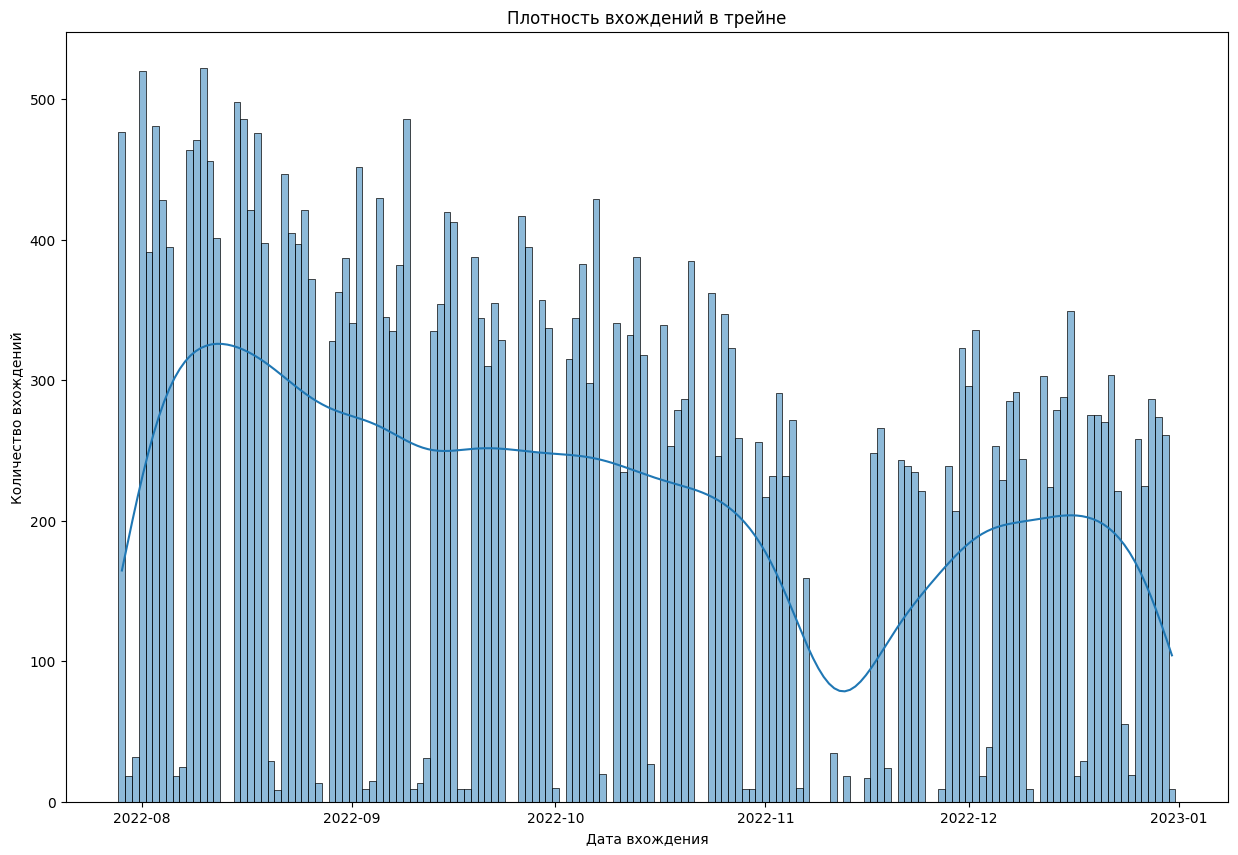

In [113]:
plt.figure(figsize = (15, 10))
sns.histplot(data = train_df['date'], bins = train_df['date'].nunique(), kde = True)
plt.title('Плотность вхождений в трейне')
plt.xlabel('Дата вхождения')
plt.ylabel('Количество вхождений')
plt.show()

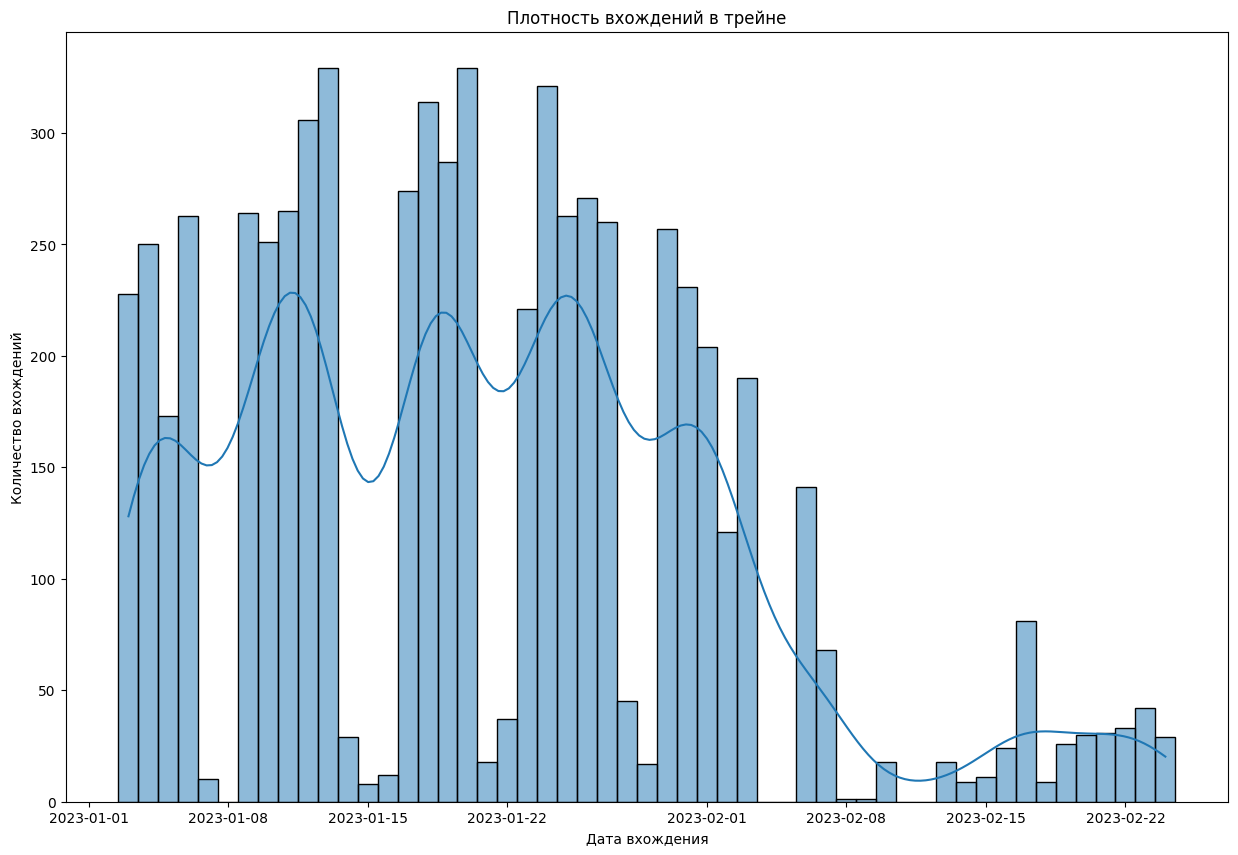

In [114]:
plt.figure(figsize = (15, 10))
sns.histplot(data = test_df['date'], bins = test_df['date'].nunique(), kde = True)
plt.title('Плотность вхождений в трейне')
plt.xlabel('Дата вхождения')
plt.ylabel('Количество вхождений')
plt.show()

---
Из графиков можно видеть, что в некоторые даты имеется сильный спад проходов через пропускные пункты. Стоит рассмотреть более подробно.


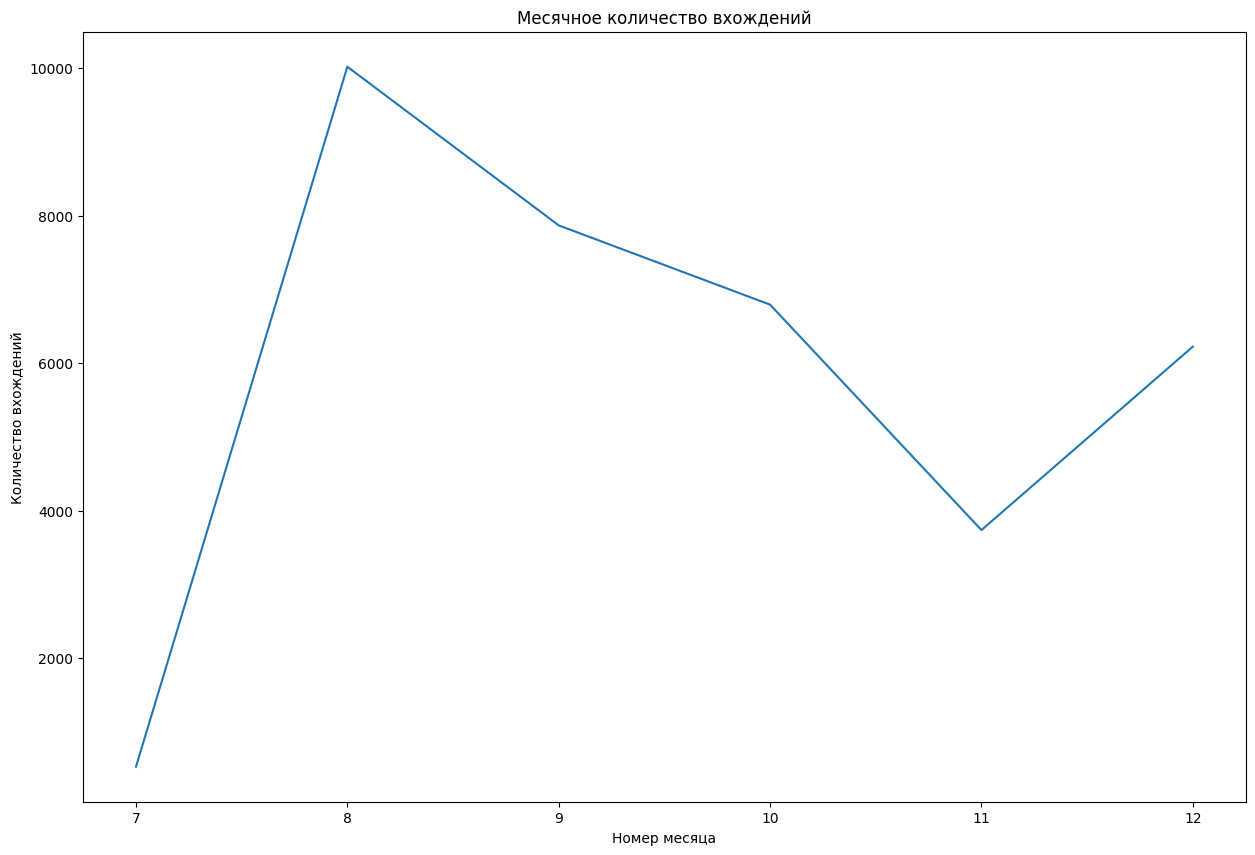

In [115]:
plt.figure(figsize = (15, 10))
train_df['month'].value_counts().sort_index().plot()
plt.title('Месячное количество вхождений')
plt.xlabel('Номер месяца')
plt.ylabel('Количество вхождений')
plt.show()

---
Месячный анализ не показал особой картины, поэтому 'опустимся' на уровень ниже - недели.

In [116]:
train_df['week_number'] = train_df['ts'].dt.isocalendar().week.astype('int64')
test_df['week_number'] = test_df['ts'].dt.isocalendar().week.astype('int64')

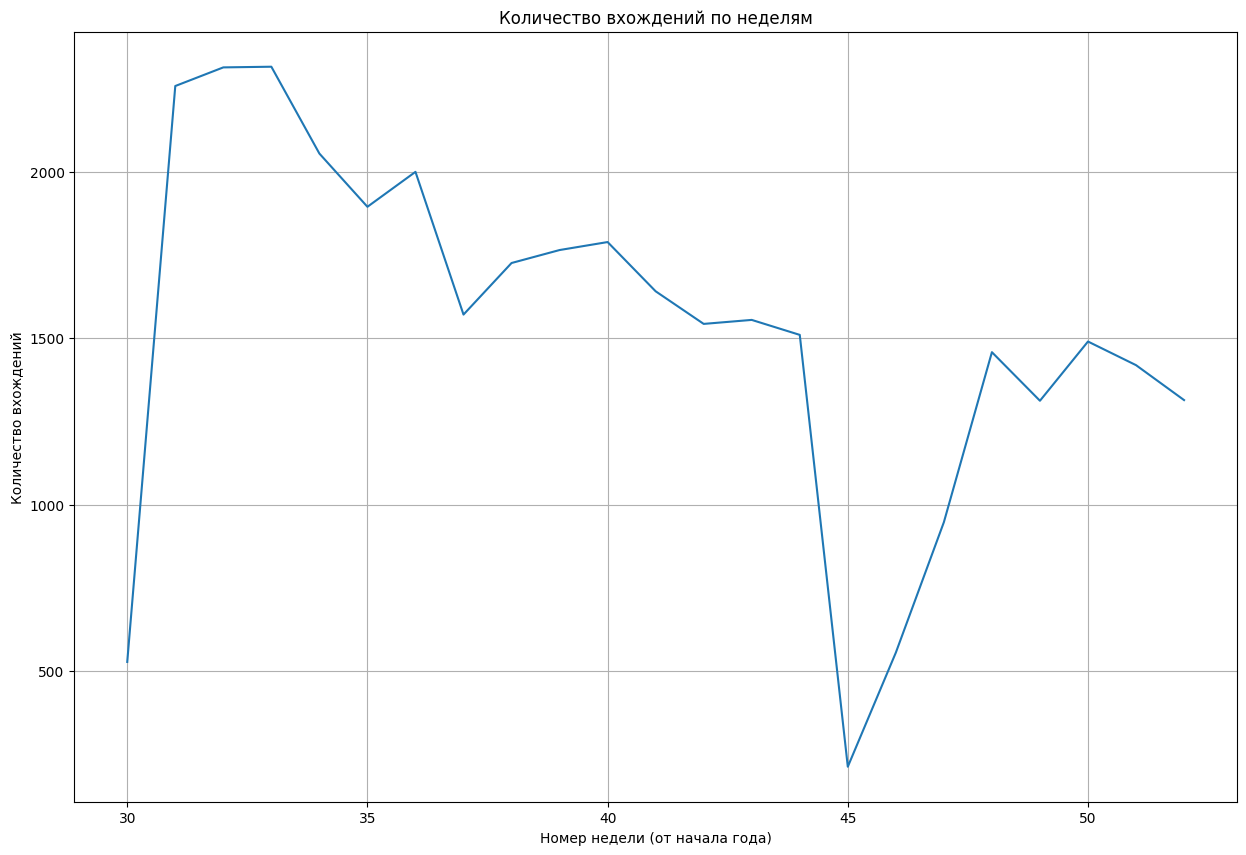

In [117]:
plt.figure(figsize = (15, 10))
train_df['week_number'].value_counts().sort_index().plot(grid = True)
plt.title('Количество вхождений по неделям')
plt.xlabel('Номер недели (от начала года)')
plt.ylabel('Количество вхождений')
plt.show()

---
Опустим пропуски на 30й неделе. Такой низкий показатель связан с тем, что логи начинаются с пятницы - последнего рабочего дня по пятидневному рабочему графику. Видно, что количество записей на 45й неделе сильно ниже всех остальных. Дополнительно введём бинарный признак - выходной ли день и затем рассмотрим всё, что имеем, более подробно.



In [118]:
train_df['is_weekend'] = (train_df['day_of_week'] > 4).astype('int64')
test_df['is_weekend'] = (test_df['day_of_week'] > 4).astype('int64')

In [119]:
train_df.loc[train_df['week_number'] == 45]['day'].value_counts().sort_index()

,count
day,
7,159
11,35
13,18


In [120]:
train_df.loc[train_df['week_number'] == 45]['is_weekend'].value_counts().sort_index()

,count
is_weekend,
0,194
1,18


---
Можно видеть, что бóльшая часть записей сделана преимущественно в рабочий день недели. Можно заметить, что записи именно на этой недели сделаны всего лишь в три дня с чередованием через день. Такие данные, из-за их амплитудности и непоследовательности, а также небольшого количества, могут привести к более размытому цифрому следу каждого из юзеров. Стоит удалить данные, которые были записаны на 45й неделе в трейне.



In [121]:
train_df = train_df.drop(train_df[train_df['week_number'] == 45].index)

---
Проведём такой же анализ и для тестовых данных

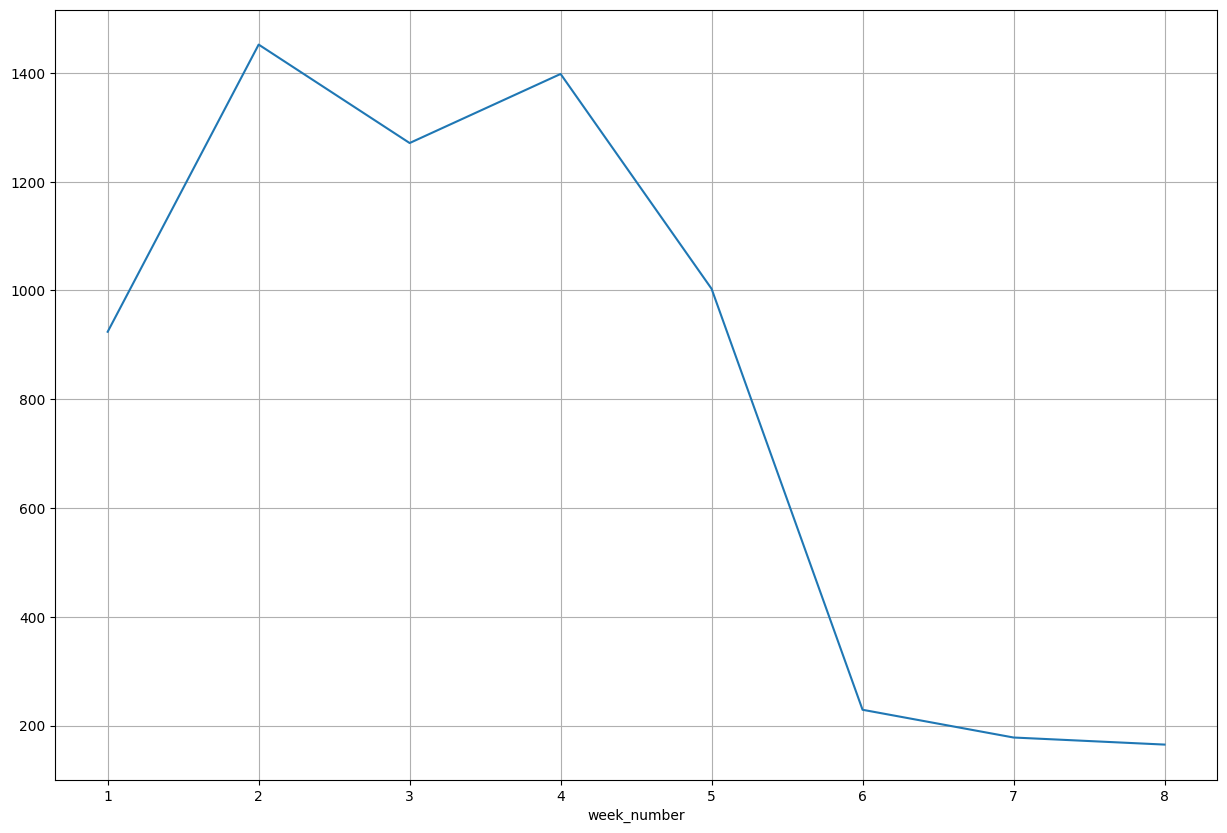

In [122]:
plt.figure(figsize = (15, 10))
test_df['week_number'].value_counts().sort_index().plot(grid = True)
plt.show()

---
Начиная с 6й неделе имеем экстремально низкие показатели. Поступим таким же образом, что и с трейном, - удалим записи за 6-8 недели из тестовых данных.

In [123]:
test_df = test_df.drop(test_df[test_df['week_number'].isin([6, 7, 8])].index)

---
Разобравшись с временными записями, стоит также провести анализ по пользователям и гейтам - использование, количество посещение и т.п.

Посмотрим на гейты.

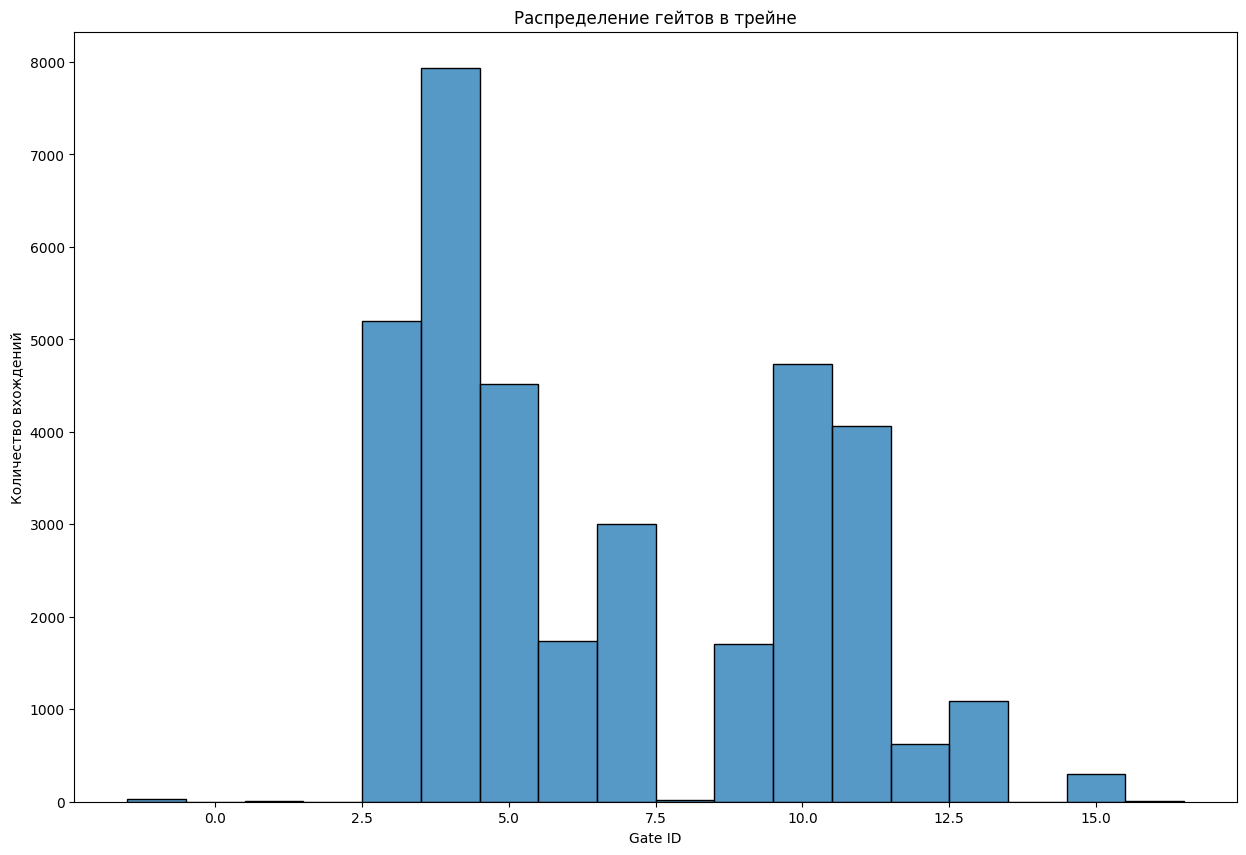

In [124]:
plt.figure(figsize=(15, 10))
sns.histplot(data=train_df, x='gate_id', bins=train_df['gate_id'].nunique(), discrete=True)

plt.xlabel("Gate ID")
plt.ylabel("Количество вхождений")
plt.title("Распределение гейтов в трейне")
plt.show()

---
Видно большой разброс в использовании гейтов, поэтому, стоит рассмотреть это в виде Series.

In [125]:
train_df['gate_id'].value_counts().sort_values(ascending = True)

,count
gate_id,
14,1
0,2
16,4
1,5
8,24
-1,25
15,296
12,619
13,1085


In [126]:
test_df['gate_id'].value_counts().sort_values(ascending = True)

,count
gate_id,
14,1
-1,1
1,2
2,4
8,10
15,88
12,120
6,269
13,296


---
В обоих датасетах имеем гейты, через которые за всё время прошли малое количество раз. Случайность? Даже если нет, то стоит помнить, что единичные значения прохождения не смогут дать общей картины. Короче говоря, - зависимости с такими данными не найдёшь. Удалим из обоих датасетов пересекающиеся гейты с количеством проходов ниже 10.

In [127]:
train_gate_del = sorted(train_df['gate_id'].value_counts()[train_df['gate_id'].value_counts() < 10].index.tolist())
test_gate_del = sorted(test_df['gate_id'].value_counts()[test_df['gate_id'].value_counts() < 10].index.tolist())
gate_del = list(set(train_gate_del).intersection(set(test_gate_del)))
print('Удаляемые гейты: ', gate_del)

Удаляемые гейты:  [1, 14]


In [128]:
train_df = train_df.drop(train_df[train_df['gate_id'].isin(gate_del)].index)
test_df = test_df.drop(test_df[test_df['gate_id'].isin(gate_del)].index)

---
Проделаем такой же анализ теперь уже и для количества проходов пользователей. Здесь стоит быть осторжным и помнить, что из теста пользователи удаляться не будут. Также, из трейна не будут удалены те пользователи, которые есть в тесте.

In [129]:
train_df['user_id'].value_counts().sort_values(ascending = True)

,count
user_id,
4,1
51,2
44,4
21,5
52,5
30,10
5,10
38,13
10,17


In [130]:
test_df['lost_id'].value_counts().sort_values(ascending = True)

,count
lost_id,
25,5
23,12
34,33
26,35
24,38
57,40
42,42
46,56
27,89


In [131]:
train_users_to_del = sorted(train_df['user_id'].value_counts()[train_df['user_id'].value_counts() < 10].index.tolist())
print('Предложенные к удалению из трейна пользователи: ', train_users_to_del)

Предложенные к удалению из трейна пользователи:  [4, 21, 44, 51, 52]


---
Проверим их принадлежность к трейну.

In [132]:
for user in train_users_to_del:
  if user in test_df['lost_id'].value_counts().index.tolist():
    train_user_to_del.remove(user)

print('Предложение к удалению из трейна пользователи, которых нет в тесте: ', train_users_to_del)

Предложение к удалению из трейна пользователи, которых нет в тесте:  [4, 21, 44, 51, 52]


---
Можно видеть, что наш список пользователей, предложенных к удалению не изменился. Смело удалим лишние записи.

In [133]:
train_df = train_df.drop(train_df[train_df['user_id'].isin(train_users_to_del)].index)

---
Рассмотрев возможные выбросы и удалив лишние данные, можно переходить к удалению лишних фичей и созданию новых. Из полученных данных будем строить бинарные фичи - проходы через каждый из турникетов, время прохода, график работы и т.д.


In [134]:
train_df.dtypes

,0
user_id,int64
ts,datetime64[ns]
gate_id,int64
date,object
month,int64
day,int64
hour,int64
minute,int64
day_of_week,int64
week_number,int64


In [135]:
test_df.dtypes

,0
ts,datetime64[ns]
gate_id,int64
lost_id,int64
date,object
month,int64
day,int64
hour,int64
minute,int64
day_of_week,int64
week_number,int64


## 2. Feature Engineering

---
Перед формированием новых фичей и общего датасета в общем удалим старые уже ненужные фичи, используемые во время EDA.

Номера недель не совпадают, тк датасет трейна содержит записи конца 2022 года (осень - зима), в то время как датасет теста содержит записи начала 2023 года (зима). Удалим, лишнюю фичу.

In [136]:
train_df = train_df.drop('week_number', axis = 1)
test_df = test_df.drop('week_number', axis = 1)

---
Попробуем вытащить пару полезных бинарных фичей из ts.

In [137]:
train_df['is_month_start'] = (train_df['ts'].dt.is_month_start).astype('int64')
train_df['is_month_end'] = (train_df['ts'].dt.is_month_end).astype('int64')

test_df['is_month_start'] = (test_df['ts'].dt.is_month_start).astype('int64')
test_df['is_month_end'] = (test_df['ts'].dt.is_month_end).astype('int64')

---
Известно, что логи данных были записаны на одном из предприятий РФ. Согласно производственному календарю за эти годы добавим гос. праздники бинарной фичей.

In [138]:
test_holidays = []

for i in range(3, 7):
  test_holidays.append(pd.Timestamp(f'2023-01-0{i}').date())

test_holidays.append(pd.Timestamp(f'2023-02-23').date())
test_holidays.append(pd.Timestamp(f'2023-02-24').date())

In [139]:
train_df['is_holiday'] = (train_df['ts'].dt.date == pd.Timestamp('2022-11-04').date()).astype('int32')
test_df['is_holiday'] = test_df['ts'].dt.date.isin(test_holidays).astype('int32')

In [140]:
train_df = train_df.drop('ts', axis = 1)
train_df = train_df.drop('date', axis = 1)

test_df = test_df.drop('ts', axis = 1)
test_df = test_df.drop('date', axis = 1)

---
Добавим разделение часов по категориям:


*   Утро - 6:00 - 11:00
*   День - 12:00 - 17:00
*   Вечер - 18:00 - 21:00
*   Ночь - 22:00 - 03:00

Общих записей промежутка 3:00 - 6:00 нет, поэтому получили такие распределения





In [141]:
train_hours = np.sort(train_df['hour'].unique())
test_hours = np.sort(test_df['hour'].unique())
print('Проходы через турникеты только в тесте', set(train_hours) - set(test_hours))
print('Проходы через турникеты только в трейне', set(test_hours) - set(train_hours))

Проходы через турникеты только в тесте {6}
Проходы через турникеты только в трейне {0, 1, 3}


In [142]:
morning_train = train_hours[:6]
day_train = train_hours[6:12]
evening_train = train_hours[12:16]
night_train = train_hours[16:]

morning_test = test_hours[3:8]
day_test = test_hours[8:14]
evening_test = test_hours[14:18]
night_test = np.array([0, 1, 3, 22, 23])

print(morning_train, day_train, evening_train, night_train)
print(morning_test, day_test, evening_test, night_test)

[ 6  7  8  9 10 11] [12 13 14 15 16 17] [18 19 20 21] [22 23]
[ 7  8  9 10 11] [12 13 14 15 16 17] [18 19 20 21] [ 0  1  3 22 23]


In [143]:
train_df['is_morning'] = train_df['hour'].isin(morning_train).astype('int64')
train_df['is_day'] = train_df['hour'].isin(day_train).astype('int64')
train_df['is_evening'] = train_df['hour'].isin(evening_train).astype('int64')
train_df['is_night'] = train_df['hour'].isin(night_train).astype('int64')

test_df['is_morning'] = test_df['hour'].isin(morning_test).astype('int64')
test_df['is_day'] = test_df['hour'].isin(day_test).astype('int64')
test_df['is_evening'] = test_df['hour'].isin(evening_test).astype('int64')
test_df['is_night'] = test_df['hour'].isin(night_test).astype('int64')

In [144]:
train_df.sample(5)

,user_id,gate_id,month,day,hour,minute,day_of_week,is_weekend,is_month_start,is_month_end,is_holiday,is_morning,is_day,is_evening,is_night
25036,18,4,10,24,13,12,0,0,0,0,0,0,1,0,0
27851,6,11,11,4,19,36,4,0,0,0,1,0,0,1,0
15516,36,5,9,16,10,16,4,0,0,0,0,1,0,0,0
9920,37,5,8,26,17,4,4,0,0,0,0,0,1,0,0
36020,17,6,12,23,20,13,4,0,0,0,0,0,0,1,0


In [145]:
test_df.sample(5)

,gate_id,lost_id,month,day,hour,minute,day_of_week,is_weekend,is_month_start,is_month_end,is_holiday,is_morning,is_day,is_evening,is_night
43533,3,37,2,1,14,56,2,0,1,0,0,0,1,0,0
40345,10,37,1,17,21,48,1,0,0,0,0,0,0,1,0
39270,4,6,1,11,19,2,2,0,0,0,0,0,0,1,0
40860,10,37,1,19,15,44,3,0,0,0,0,0,1,0,0
41537,10,15,1,23,16,40,0,0,0,0,0,0,1,0,0


In [146]:
print(train_df.shape, test_df.shape)

(34937, 15) (6045, 15)


---
Теперь разделим каждый час по четвертям. Такие бинарные фичи, описывающие ключевые моменты времени лучше помогают увидеть паттерны различных юзеров.

In [147]:
first_quarter_list = list(range(0, 15))
second_quarter_list = list(range(15, 30))
third_quarter_list = list(range(30, 45))
fourth_quarter_list = list(range(45, 60))

In [148]:
train_df['first_quarter'] = train_df['minute'].isin(first_quarter_list).astype('int64')
train_df['second_quarter'] = train_df['minute'].isin(second_quarter_list).astype('int64')
train_df['third_quarter'] = train_df['minute'].isin(third_quarter_list).astype('int64')
train_df['fourth_quarter'] = train_df['minute'].isin(fourth_quarter_list).astype('int64')

test_df['first_quarter'] = test_df['minute'].isin(first_quarter_list).astype('int64')
test_df['second_quarter'] = test_df['minute'].isin(second_quarter_list).astype('int64')
test_df['third_quarter'] = test_df['minute'].isin(third_quarter_list).astype('int64')
test_df['fourth_quarter'] = test_df['minute'].isin(fourth_quarter_list).astype('int64')

---
Проделаем то же самое для дней недели, создав новые 7 фичей.

In [149]:
train_df['day_of_week'].value_counts().sort_index()

,count
day_of_week,
0,6707
1,6225
2,6714
3,7145
4,7355
5,574
6,217


In [150]:
test_df['day_of_week'].value_counts().sort_index()

,count
day_of_week,
0,754
1,1304
2,1296
3,1158
4,1370
5,101
6,62


In [151]:
days = list(range(0, 7))

for i in range(len(days)):
  def new_day(row):
    if days[i] == row:
      return 1
    else:
      return 0

  train_df[f'day_of_week_{i}'] = train_df['day_of_week'].apply(new_day)
  test_df[f'day_of_week_{i}'] = test_df['day_of_week'].apply(new_day)

In [152]:
train_df.sample(7)

,user_id,gate_id,month,day,hour,minute,day_of_week,is_weekend,is_month_start,is_month_end,...,second_quarter,third_quarter,fourth_quarter,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
34165,54,9,12,15,20,28,3,0,0,0,...,1,0,0,0,0,0,1,0,0,0
5123,48,3,8,12,11,24,4,0,0,0,...,1,0,0,0,0,0,0,1,0,0
9060,37,11,8,24,16,18,2,0,0,0,...,1,0,0,0,0,1,0,0,0,0
18143,14,11,9,26,20,52,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
960,18,10,8,1,17,28,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
1384,18,7,8,2,16,28,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
7598,19,12,8,19,14,4,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [153]:
test_df.sample(7)

,gate_id,lost_id,month,day,hour,minute,day_of_week,is_weekend,is_month_start,is_month_end,...,second_quarter,third_quarter,fourth_quarter,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
39089,5,14,1,11,10,18,2,0,0,0,...,1,0,0,0,0,1,0,0,0,0
41949,11,50,1,24,20,36,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
43892,7,15,2,3,15,14,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0
42490,4,33,1,26,19,13,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
41717,5,48,1,24,11,44,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
42516,11,9,1,26,20,4,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
41648,5,47,1,24,10,11,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


---
Аналогично для гейтов

In [154]:
train_gates = list(np.sort(train_df['gate_id'].unique()))
test_gates = list(np.sort(test_df['gate_id'].unique()))
print(train_gates, test_gates)

[-1, 0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16] [-1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]


In [155]:
general_gates = list(set(train_gates + test_gates))
general_gates

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, -1]

In [156]:
for i in range(len(general_gates)):
  def new_gate(row):
    if general_gates[i] == row:
      return 1
    else:
      return 0

  train_df[f'gate_{general_gates[i]}'] = train_df['gate_id'].apply(new_gate)
  test_df[f'gate_{general_gates[i]}'] = test_df['gate_id'].apply(new_gate)

print(train_df.shape, test_df.shape)
print(train_df.columns, '\n', test_df.columns)

(34937, 42) (6045, 42)
Index(['user_id', 'gate_id', 'month', 'day', 'hour', 'minute', 'day_of_week',
       'is_weekend', 'is_month_start', 'is_month_end', 'is_holiday',
       'is_morning', 'is_day', 'is_evening', 'is_night', 'first_quarter',
       'second_quarter', 'third_quarter', 'fourth_quarter', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'gate_0', 'gate_2', 'gate_3',
       'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8', 'gate_9', 'gate_10',
       'gate_11', 'gate_12', 'gate_13', 'gate_15', 'gate_16', 'gate_-1'],
      dtype='object') 
 Index(['gate_id', 'lost_id', 'month', 'day', 'hour', 'minute', 'day_of_week',
       'is_weekend', 'is_month_start', 'is_month_end', 'is_holiday',
       'is_morning', 'is_day', 'is_evening', 'is_night', 'first_quarter',
       'second_quarter', 'third_quarter', 'fourth_quarter', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', '

---
Аналогично для дней месяца по числам

In [157]:
train_days = list(np.sort(train_df['day'].unique()))
test_days = list(np.sort(test_df['day'].unique()))
print(train_days, '\n', test_days)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] 
 [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [158]:
train_days == test_days

False

In [159]:
print(len(train_days), len(test_days))

31 30


In [160]:
general_days = list(range(1, 32))
general_days.remove(list(set(train_days) - set(test_days))[0])
general_days

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

In [161]:
for i in range(len(general_days)):
  def new_day(row):
    if general_days[i] == row:
      return 1
    else:
      return 0

  train_df[f'day_{general_days[i]}'] = train_df['day'].apply(new_day)
  test_df[f'day_{general_days[i]}'] = test_df['day'].apply(new_day)

In [162]:
print(train_df.shape, test_df.shape)
print(train_df.columns, test_df.columns)

(34937, 72) (6045, 72)
Index(['user_id', 'gate_id', 'month', 'day', 'hour', 'minute', 'day_of_week',
       'is_weekend', 'is_month_start', 'is_month_end', 'is_holiday',
       'is_morning', 'is_day', 'is_evening', 'is_night', 'first_quarter',
       'second_quarter', 'third_quarter', 'fourth_quarter', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'gate_0', 'gate_2', 'gate_3',
       'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8', 'gate_9', 'gate_10',
       'gate_11', 'gate_12', 'gate_13', 'gate_15', 'gate_16', 'gate_-1',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_9',
       'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16',
       'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30',
       'day_31'],
      dtype='object') Index(['gate_id', 'lost_id', 'mo

---
Добавим графики работы 2 через 2 (со смещением и без него).

In [163]:
train_df['2x2_1'] = (train_df['day'] % 4).apply(lambda x: x in (1, 2)).astype('int32')
train_df['2x2_2'] = (train_df['day'] % 4).apply(lambda x: x < 2).astype('int32')

test_df['2x2_1'] = (test_df['day'] % 4).apply(lambda x: x in (1, 2)).astype('int32')
test_df['2x2_2'] = (test_df['day'] % 4).apply(lambda x: x < 2).astype('int32')

---
Теперь разобьём часы так же на бинарные фичи.

In [164]:
print(train_df['hour'].nunique(), test_df['hour'].nunique())

18 20


In [165]:
print(train_hours, '\n', test_hours)
general_hours = [x for x in range(24) if x in train_hours and x in test_hours]
general_hours

[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] 
 [ 0  1  3  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [166]:
for i in range(len(general_hours)):
  def new_hour(row):
    if general_hours[i] == row:
      return 1
    else:
      return 0

  train_df[f'hour_{general_hours[i]}'] = train_df['hour'].apply(new_hour)
  test_df[f'hour_{general_hours[i]}'] = test_df['hour'].apply(new_hour)

In [ ]:
train_df = train_df.drop(['month', 'day'], axis = 1)
test_df = test_df.drop(['month', 'day'], axis = 1)

In [167]:
print(train_df.shape, test_df.shape)
print(train_df.columns, test_df.columns)

(34937, 91) (6045, 91)
Index(['user_id', 'gate_id', 'month', 'day', 'hour', 'minute', 'day_of_week',
       'is_weekend', 'is_month_start', 'is_month_end', 'is_holiday',
       'is_morning', 'is_day', 'is_evening', 'is_night', 'first_quarter',
       'second_quarter', 'third_quarter', 'fourth_quarter', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'gate_0', 'gate_2', 'gate_3',
       'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8', 'gate_9', 'gate_10',
       'gate_11', 'gate_12', 'gate_13', 'gate_15', 'gate_16', 'gate_-1',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_9',
       'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16',
       'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30',
       'day_31', '2x2_1', '2x2_2', 'hour_7', 'hour_8', 'hour_9', 'hour_1

## 3. Обучение различных моделей на полученных данных.

### 3.0. Разделение на фичи и таргет. Нормализация данных.

In [168]:
X_train = train_df.drop('user_id', axis = 1)
y_train = train_df['user_id']

X_submit = test_df.drop('lost_id', axis = 1)

In [169]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_submit_scaled = scaler.transform(X_submit)

### 3.1. Логистическая регрессия

In [170]:
ovr = OneVsRestClassifier(
    LogisticRegressionCV(
        solver = 'lbfgs',
        penalty = 'l2',
        random_state = 52,
  )
)

In [171]:
ovr.fit(X_train_scaled, y_train)

OneVsRestClassifier(estimator=LogisticRegressionCV(random_state=52))

### 3.2. Решающие деревья (CatBoost)

In [172]:
ovr = OneVsRestClassifier(
    CatBoostClassifier(
        iterations = 500,
        objective = 'MultiClassOneVsAll',
        l2_leaf_reg = 5,
        random_seed = 52,
        thread_count = 1,
    )
)

In [173]:
ovr.fit(X_train_scaled, y_train)

0:	learn: 0.6678369	total: 65.1ms	remaining: 32.5s
1:	learn: 0.6438655	total: 82.6ms	remaining: 20.6s
2:	learn: 0.6211250	total: 96.8ms	remaining: 16s
3:	learn: 0.5995960	total: 112ms	remaining: 13.9s
4:	learn: 0.5792552	total: 132ms	remaining: 13s
5:	learn: 0.5601174	total: 148ms	remaining: 12.2s
6:	learn: 0.5419804	total: 165ms	remaining: 11.6s
7:	learn: 0.5247780	total: 183ms	remaining: 11.3s
8:	learn: 0.5085358	total: 201ms	remaining: 11s
9:	learn: 0.4929691	total: 219ms	remaining: 10.7s
10:	learn: 0.4781449	total: 237ms	remaining: 10.5s
11:	learn: 0.4639803	total: 252ms	remaining: 10.3s
12:	learn: 0.4505492	total: 275ms	remaining: 10.3s
13:	learn: 0.4377027	total: 291ms	remaining: 10.1s
14:	learn: 0.4254875	total: 308ms	remaining: 9.95s
15:	learn: 0.4139345	total: 325ms	remaining: 9.82s
16:	learn: 0.4028076	total: 343ms	remaining: 9.73s
17:	learn: 0.3921803	total: 360ms	remaining: 9.64s
18:	learn: 0.3819966	total: 374ms	remaining: 9.48s
19:	learn: 0.3722589	total: 390ms	remaining:

KeyboardInterrupt: 

### 3.3. Стекинг моделей

In [ ]:
ensemble = StackingClassifier(
    estimators=[
        ('catboost', OneVsRestClassifier(CatBoostClassifier(
            iterations = 500, objective = 'MultiClassOneVsAll', l2_leaf_reg = 5,
            random_seed = 52, thread_count = 1
        ))),
        ('logreg', OneVsRestClassifier(LogisticRegressionCV(
            solver = 'lbfgs', penalty = 'l2', random_state = 52, max_iter = 500,
        )))
    ],
    final_estimator = LogisticRegressionCV()
)

In [ ]:
ensemble.fit(X_train_scaled, y_train)
preds = ensemble.predict(X_submit_scaled)

### 3.4. Метод опорных векторов (SVM)

In [ ]:
svm = SVC(kernel = 'rbf', gamma = 'scale', decision_function_shape = 'ovr', random_state = 52)

param_grid = { 'C': [0.1, 1, 10, 100] }

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

In [ ]:
best_model.fit(X_train_scaled, y_train)
preds = best_model.predict(X_submit_scaled)

### 3.5. Многослойный перцептрон (MLP)

In [ ]:
model = k.Sequential([
    Input((85, )),

    Dense(512, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dense(512, activation = 'relu'),

    Dense(256, activation = 'relu'),
    Dense(256, activation = 'relu'),

    Dense(128, activation = 'relu'),

    Dense(64, activation = 'relu'),

    Dense(58, activation = 'softmax')
])


model.compile( optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size = 0.15,
                                                  stratify = y_train, random_state = 52)

early_stopping = k.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 1,
)

model.fit(X_train, y_train, validation_data = (X_val, y_val), callbacks = early_stopping, epochs = 100)

In [ ]:
preds = model.predict(X_submit_scaled).argmax(axis = 1)

## 4. Заключение

In [ ]:
submit = pd.DataFrame()
submit['lost_id'] = test_df['lost_id']
submit['preds'] = preds

submit.head(5)

,lost_id,preds
37518,1,3
37520,1,3
37521,1,3
37522,1,3
37523,19,1


In [ ]:
print(submit['preds'].unique())
print(submit['preds'].nunique())

[ 3  1 17 39 12 11 37 49 54  6 55 56 47 32 48 50 15 18 19 35  9 40 14 53
 29  0 27 33  7 31 42 24 43 23 25 34 57 46 28 45 41 26]
42


In [ ]:
submit_file = pd.DataFrame(
    submit.groupby('lost_id')['preds'].agg(
        lambda x: x.value_counts().index[0]
    )
)
submit_file

,preds
lost_id,
0,55
1,15
3,11
6,9
9,32
11,3
12,15
14,11
15,12


In [ ]:
temp_df = submit['lost_id'].value_counts(ascending = False)
temp_df

,count
lost_id,
37,633
55,447
6,390
12,329
19,303
18,277
53,268
15,252
47,234


In [ ]:
new_users = sorted(list(temp_df[temp_df < 60].index))
new_users

[23, 24, 25, 26, 34, 42, 46, 57]

In [ ]:
submit_file['preds'] = submit_file.apply(
    lambda row: -999 if row.name in new_users else row['preds'],
    axis=1
)
submit_file.iloc[24:25] = 13
submit_file

,preds
lost_id,
0,55
1,15
3,11
6,9
9,32
11,3
12,15
14,11
15,12


In [ ]:
submit_file.to_csv('answer.csv')